In [145]:
import torch.nn as nn
import torch.nn.functional as F

In [146]:
# Alternate Approach Investigation

states = 4
batches = 13

In [147]:
# Our initial transition tensors
transition_tensor = torch.softmax(torch.randn(batches, states, states), dim = 1)

# The columns must sum to 1
batch_sel = 5
col_sel = 3

print(transition_tensor[batch_sel,:,col_sel].sum())
print(transition_tensor.sum(dim = 1))

tensor(1.)
tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]])


In [148]:
# Our state tensor, which must sum to one for each batch

state_tensor = torch.softmax(torch.randn(batches, states), dim = 1)
state_tensor[0,:].sum()

tensor(1.)

In [149]:
# When we multiply our transition tensor by our state tensor, we expect the results to also normalize
new_state = torch.bmm(transition_tensor, state_tensor.unsqueeze(2))
new_state[2,:].sum()

tensor(1.)

In [150]:
# Now that the transitions and states look good, lets create our norm subgroups
norm_subgroups = torch.cat([state_tensor.unsqueeze(2), transition_tensor], dim = 2) # [batches, states, states + 1]

In [151]:
# Now we will set up our interaction matrices.
interaction_tensors = torch.softmax(torch.randn(states, states, states, states + 1), dim = 0)

In [152]:
# The naive approach: loop through each interaction tensor over states + 1:
for indx in range(states + 1):
    interaction_tensor = interaction_tensors[:,:,:,indx] # [states, states, states]
    norm_subgroup = norm_subgroups[:,:,indx] # [batches, states]
    
    # To check, a single mult would look like this
    batch_sel = 5
    col_sel = 3
    row_sel = 2
    example_transition_tensor = torch.matmul(interaction_tensor, norm_subgroup[batch_sel,:])
    # This example transition tensor is not over the batches, but it should sum to one:
    print("Example transition Tensor sum: ",example_transition_tensor[:,col_sel].sum())
    print("Example transition tensor spot check: ", example_transition_tensor[row_sel, col_sel])
    example_new_state = torch.matmul(example_transition_tensor, norm_subgroup[batch_sel,:])
    print("Example New State Sum: ", example_new_state.sum())
    print("Example New State Spot Check: ", example_new_state[col_sel])
    
    # Now let's try recreating this across all batches
    #transition_tensor = torch.mul(interaction_tensor, norm_subgroup.unsqueeze(1).unsqueeze(1)).sum(3)
    transition_tensor = torch.mul(interaction_tensor, norm_subgroup.unsqueeze(1).unsqueeze(1)).sum(-1) 
    print("Batched transition tensor spot check: ",transition_tensor[batch_sel,row_sel,col_sel])
    
    # Now we just combine with our norm_subgroup
    new_state = torch.bmm(transition_tensor, norm_subgroup.unsqueeze(2)).squeeze(2)
    print("Batched New State Sum: ",sum(new_state[batch_sel,:]))
    print("Batched New State Spot Check: ", new_state[batch_sel,col_sel])

    

Example transition Tensor sum:  tensor(1.0000)
Example transition tensor spot check:  tensor(0.2106)
Example New State Sum:  tensor(1.)
Example New State Spot Check:  tensor(0.4447)
Batched transition tensor spot check:  tensor(0.2106)
Batched New State Sum:  tensor(1.)
Batched New State Spot Check:  tensor(0.4447)
Example transition Tensor sum:  tensor(1.)
Example transition tensor spot check:  tensor(0.2601)
Example New State Sum:  tensor(1.)
Example New State Spot Check:  tensor(0.2322)
Batched transition tensor spot check:  tensor(0.2601)
Batched New State Sum:  tensor(1.)
Batched New State Spot Check:  tensor(0.2322)
Example transition Tensor sum:  tensor(1.)
Example transition tensor spot check:  tensor(0.2543)
Example New State Sum:  tensor(1.)
Example New State Spot Check:  tensor(0.2770)
Batched transition tensor spot check:  tensor(0.2543)
Batched New State Sum:  tensor(1.)
Batched New State Spot Check:  tensor(0.2770)
Example transition Tensor sum:  tensor(1.0000)
Example tr

In [153]:
# # Now that this looks good, let's see if we can do it without the loop
# transition_tensors = torch.mul(interaction_tensors, norm_subgroups.unsqueeze(1).unsqueeze(1)).sum(3) # [batches, states, states, states + 1]
# new_states = torch.bmm(transition_tensors, norm_subgroups.unsqueeze(2)).squeeze(2)

In [154]:
# We can't do bmm without the loop so let's just keep it like this for now:
transitions_list = []
new_state_list = []
# The naive approach: loop through each interaction tensor over states + 1:
for indx in range(states + 1):
    interaction_tensor = interaction_tensors[:,:,:,indx] # [states, states, states]
    norm_subgroup = norm_subgroups[:,:,indx] # [batches, states]
    
    transition_tensor = torch.mul(interaction_tensor, norm_subgroup.unsqueeze(1).unsqueeze(1)).sum(3)
    # Now we just combine with our norm_subgroup
    new_state = torch.bmm(transition_tensor, norm_subgroup.unsqueeze(2)).squeeze(2)
    
    new_state_list.append(new_state)
    transitions_list.append(transition_tensor)
    
transition_tensors = torch.stack(transitions_list, -1)
new_states = torch.stack(new_state_list, -1)

In [155]:
# Now let's test with some example weights
weights = torch.randn(batches, states+1)
new_states_weighted = torch.mul(new_states,weights.unsqueeze(1)).sum(-1)

# To check:
print(sum(weights[batch_sel,:] * new_states[batch_sel,3,:]))
print(new_states_weighted[batch_sel,:])

tensor(1.1356)
tensor([0.8249, 0.6943, 0.8902, 1.1356])


In [156]:
class NeuralCoilLayer(nn.Module):
    def __init__(self, n_features, n_batch, device = "cpu"):
        super(NeuralCoilLayer, self).__init__()
        self.n_features = n_features
        self.attention_weights = nn.Linear(n_features, 1, bias=False)
        self.act = nn.SiLU()
        self.interaction_tensors = nn.Parameter(torch.randn(n_features, n_features, n_features, n_features + 1))
        
        self.transition_tensor = torch.zeros(n_batch, n_features, n_features)
        if device == "cuda":
            self.transition_tensor = self.transition_tensor.to("cuda")

        
    def step_coil(self, state_tensor, transition_tensor):
        states = state_tensor.shape[1]
        
        # Establish normalized subgroups
        norm_subgroups = torch.cat([state_tensor.unsqueeze(2), transition_tensor], dim = 2) # [batch_size, states, states + 1]
        # Compute scores for each normalized subgroup
        scores = self.act(self.attention_weights(norm_subgroups.permute(0,2,1))).sum(-1) # [batch_size, states + 1]
        
        weights = torch.softmax(scores,dim = -1) # [batch_size, states + 1]
        
        # We can't do bmm without the loop so let's just keep it like this for now:
        transitions_list = []
        new_state_list = []
        # The naive approach: loop through each interaction tensor over states + 1:
        for indx in range(states + 1):
            interaction_tensor = self.interaction_tensors[:,:,:,indx] # [states, states, states]
            norm_subgroup = norm_subgroups[:,:,indx] # [batches, states]
            
            transition_tensor = torch.mul(interaction_tensor, norm_subgroup.unsqueeze(1).unsqueeze(1)).sum(3) # [batches, states, states]
            # Now we just combine with our norm_subgroup
            new_state = torch.bmm(transition_tensor, norm_subgroup.unsqueeze(2)).squeeze(2) # [batches, state]
            
            new_state_list.append(new_state)
            transitions_list.append(transition_tensor)
            
        transition_tensors = torch.stack(transitions_list, -1) # [batches, states, states, states + 1]
        new_states = torch.stack(new_state_list, -1) # [batches, states, states + 1]
        
        # Apply weights to transition tensors and new_states to get down into one state
        new_state = torch.softmax((torch.mul(new_states, weights.unsqueeze(1))).sum(-1), dim = 1)
        transition_tensor = torch.softmax(torch.mul(transition_tensors, weights.unsqueeze(1).unsqueeze(1)).sum(-1), dim = 1)
        
        return new_state, transition_tensor


    def forward(self, x):
        batch, length, n_features = x.size()
        output = x.new_empty(batch, length, n_features)

        # Initialize previous transition tensors (for the first step)
        # Assuming it's a list of zero tensors for simplicity
        transition_tensor = self.transition_tensor

        for l in range(length):
            state_tensor = x[:, l, :]
            
            # Compute output for this step
            output[:, l, :], transition_tensor = self.step_coil(state_tensor, transition_tensor)

        return output, transition_tensor


In [157]:
n_features = 16
batch, length, dim = 13, 64, n_features
x = torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features,
    n_batch=batch
)
y = model(x)


print(y[0].shape)
assert y[0].shape == x.shape

torch.Size([13, 64, 16])


In [158]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(x)
        
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
       model_inference        23.84%     174.901ms       100.00%     733.526ms     733.526ms             1  
             aten::sum        21.69%     159.074ms        23.36%     171.388ms     133.897us          1280  
             aten::mul        21.03%     154.246ms        21.03%     154.246ms     126.847us          1216  
           aten::slice         8.39%      61.519ms         9.11%      66.844ms      11.353us          5888  
       aten::unsqueeze         5.74%      42.095ms         6.41%      47.006ms       8.252us          5696  
           aten::stack         1.33%       9.731ms         4.27%      31.342ms     244.859us           128  
             aten::

In [159]:
n_features = 4
batch, length, dim = 13, 64, n_features
x =torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features,
    n_batch=batch
)

l = 1
state_tensor = x[:, l, :]
print(state_tensor[1,:])
transition_tensor = torch.randn(batch, n_features, n_features)
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])

tensor([-0.2011, -1.8600, -0.2060,  0.0955])
tensor([2.3367e-01, 2.3087e-02, 7.4314e-01, 1.0196e-04],
       grad_fn=<SliceBackward0>)
tensor([2.3367e-01, 2.3087e-02, 7.4314e-01, 1.0196e-04],
       grad_fn=<SliceBackward0>)


This should be the same as if we just look at the batches independently

In [160]:
batch = 2
transition_tensor = transition_tensor[0:2,:,:]
l = 1
state_tensor = x[0:2, l, :]
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
new_state[1,:]

tensor([2.3367e-01, 2.3087e-02, 7.4314e-01, 1.0196e-04],
       grad_fn=<SliceBackward0>)

In [161]:
states = []
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor)

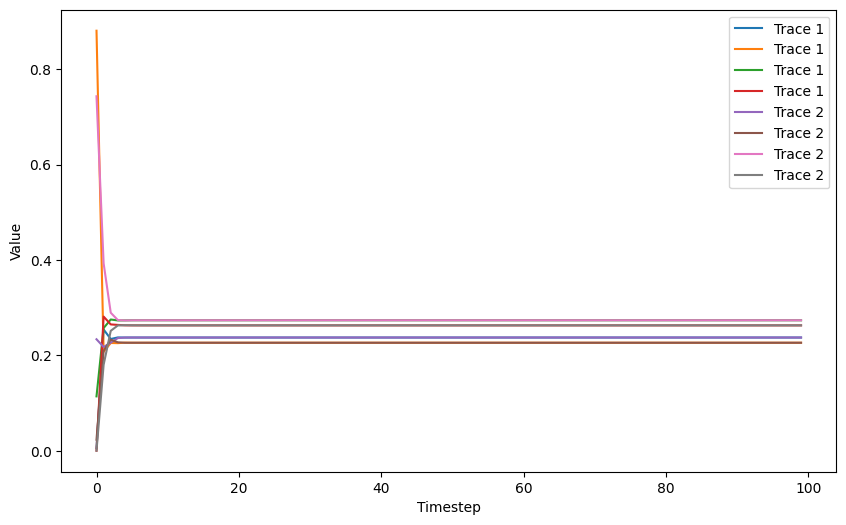

In [162]:
import matplotlib.pyplot as plt

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

In [163]:
import numpy as np
import torch

def generate_normalized_multivariate_time_series(n_features, total_length, amplitude=1.0):
    t = np.linspace(0, 100 * np.pi, total_length)
    series = np.zeros((total_length, n_features))
    for i in range(n_features):
        series[:, i] = amplitude * np.cos(t * (i + 1) / n_features) + 10
    
    # Normalize such that each timestep's values sum to 1
    series_sum = np.sum(series, axis=1, keepdims=True)
    series_normalized = series / series_sum
    
    return series_normalized

def segment_time_series(series, length):
    # Assuming series is a numpy array of shape [total_length, n_features]
    total_length, n_features = series.shape
    segments = []
    for start in range(0, total_length - length, length):
        segment = series[start:start + length]
        segments.append(segment)
    return np.stack(segments)

In [164]:
n_features = 4
length = 64  # Segment length
total_length = 1024  # Arbitrary total length for the generated series

# Generate and segment the time series
series = generate_normalized_multivariate_time_series(n_features, total_length)
series_x = series[:-1,]
series_y = series[1:,]

segments_x = segment_time_series(series_x, length)
segments_y = segment_time_series(series_y, length)

# Convert to tensors
segments_tensor_x = torch.tensor(segments_x, dtype=torch.float)
segments_tensor_y = torch.tensor(segments_y, dtype=torch.float)

# Prepare inputs and targets
X = segments_tensor_x.to("cuda")
# Shift segments to the right by one timestep to create the targets
Y =  segments_tensor_y.to("cuda")

In [168]:
from torch import nn, optim

class CoilBlock(nn.Module):
    def __init__(self, n_features, n_batch, device):
        super(CoilBlock, self).__init__()

        self.coil1 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
        self.coil2 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
        self.coil3 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
    
    def forward(self, x):
        x, transition_tensor = self.coil1(x)
        x, transition_tensor = self.coil2(x)
        #x, transition_tensor = self.coil3(x)
        return x, transition_tensor
    
# Model
model = NeuralCoilLayer(
    n_features = n_features,
    n_batch = X.shape[0],
    device="cuda"
).to("cuda")
#model = CoilBlock(n_features=n_features, n_batch= X.shape[0], device="cuda").to("cuda")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs, transition_tensor = model(X)
    loss = criterion(outputs, Y)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')


Epoch [10/5000], Loss: 0.0004000483895651996
Epoch [20/5000], Loss: 0.00024131684040185064
Epoch [30/5000], Loss: 0.00026145868469029665
Epoch [40/5000], Loss: 0.0002340801147511229


KeyboardInterrupt: 

In [169]:
import plotly.graph_objects as go

def plot_model_output_vs_target(model_outputs, targets, batch_index=0, feature_index=0):
    # Extract the specified feature for the given batch from both the model outputs and targets
    model_output_series = model_outputs[batch_index, :, feature_index].detach().numpy()
    target_series = targets[batch_index, :, feature_index].numpy()
    
    # Create a range for the x-axis (timesteps)
    timesteps = list(range(model_output_series.shape[0]))
    
    # Create traces
    model_trace = go.Scatter(x=timesteps, y=model_output_series, mode='lines', name='Model Output')
    target_trace = go.Scatter(x=timesteps, y=target_series, mode='lines', name='Target')
    
    # Create the figure and add traces
    fig = go.Figure()
    fig.add_trace(model_trace)
    fig.add_trace(target_trace)
    
    # Add title and labels
    fig.update_layout(title=f'Model Output vs Target for Feature {feature_index}, Batch {batch_index}',
                      xaxis_title='Timestep',
                      yaxis_title='Value')
    
    # Show the figure
    fig.show()

# Assuming `y` and `Y` are your model outputs and targets, respectively
# Adjust batch_index and feature_index as needed
plot_model_output_vs_target(outputs.to("cpu"), Y.to("cpu"), batch_index=3, feature_index=3)


tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tens

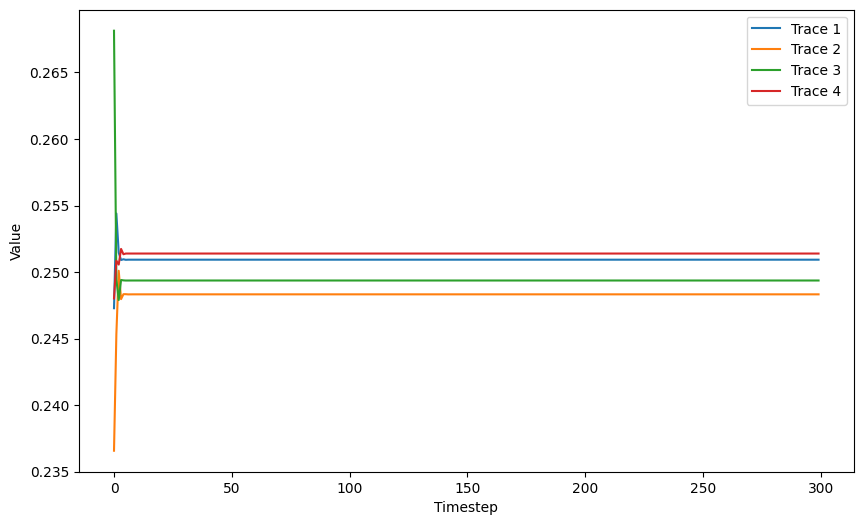

In [170]:
states = []
batch = 3
state_tensor = X[:,0,:]
batch_size = 15
transition_tensor = torch.zeros(batch_size, n_features, n_features).to("cuda")
for step_state in range(300):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor[batch,:])
    print(sum(state_tensor[batch,:]))
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()